In [16]:
"""
Created on Mon Sep 25 08:07:53 2023
@author: Cristhiam Martínez crismartinez@t-online.de
"""

import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.spatial.distance import cdist
# change for scikit-learn
import sklearn
from sklearn import preprocessing
from sklearn import cluster
import pandas as pd
import soundfile as sf
from pathlib import Path
from IPython.display import display
import IPython.display as ipd

def extract_features(x, window=scipy.signal.windows.bartlett, n_fft=None):
    if n_fft:
        hop_length = int(n_fft/4)
        flat = librosa.feature.spectral_flatness(y=x, window=window, n_fft=n_fft, hop_length=hop_length)[0,0] #tonality coefficient
        c = librosa.feature.spectral_centroid(y=x, window=window, n_fft=n_fft, hop_length=hop_length)[0].mean() # take the mean of the SC
    else:
        flat = librosa.feature.spectral_flatness(y=x, window=window)[0,0] #tonality coefficient
        c = librosa.feature.spectral_centroid(y=x, window=window)[0].mean() # take the mean of the SC
    return flat, c

def concatenate_short_onsets(x, snare_samples, pad_duration=0.900):
    silence = np.zeros(int(pad_duration*sr)) # silence
    frame_sz = int(min(np.diff(snare_samples))*0.45)   # every segment has uniform frame size
    return np.concatenate([
        np.concatenate([x[i:i+frame_sz], silence]) # pad segment with silence
        for i in snare_samples
    ])

def concatenate_onsets(x, snare_samples, pad_duration=0.900):
    silence = np.zeros(int(pad_duration*sr)) # silence
    frame_sz = min(np.diff(snare_samples))   # every segment has uniform frame size
    return np.concatenate([
        np.concatenate([x[i:i+frame_sz], silence]) # pad segment with silence
        for i in snare_samples
    ])

def write_click_wav(reference_audio, sr):
    for i in range(n_clusters):
        click_track = librosa.clicks (frames=onset_frames[labels == i], sr=sr, length=len (reference_audio))
        
        # Example audio file path to save
        output_path = f'Cluster{i+1}.wav'
        
        # Extract audio data from clicks1
        audio_data = reference_audio + click_track
        
        # Write the audio data to a WAV file
        sf.write (output_path, audio_data, sr)

def extract_onset_information(audio):
    frames = librosa.onset.onset_detect (y=audio, sr=sr, backtrack=True, hop_length=512)
    times = librosa.frames_to_time (frames)
    samples = librosa.frames_to_samples (frames)
    return frames, times, samples

def extract_onset_indices(onset_frames, onset_samples, onset_times, indices):
    """access the snares from the signal through the extracted
    indexes and convert them from frames to samples and times"""
    frames = onset_frames[indices]
    samples = onset_samples[indices]
    times = onset_times[indices]
    return frames, samples, times



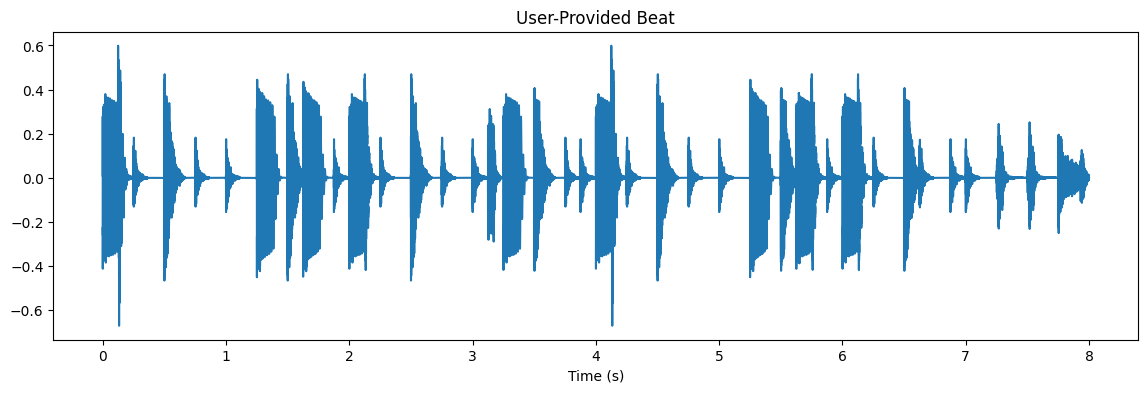

In [17]:
# Load audio
audio = r"C:\Users\LEGION\PycharmProjects\GTS DATA SET\BeatClean.wav"
original_audio, sr = librosa.load(audio, duration = 8.0)
time_ms = np.linspace(0, len(original_audio) / 22050, len(original_audio))

#plot
plt.figure(figsize=(14,4))
plt.plot(time_ms,original_audio)
plt.xlabel("Time (s)")  # Label for clarity
plt.title('User-Provided Beat')
plt.show()
plt.close()

# listen
ipd.Audio(original_audio, rate=sr)


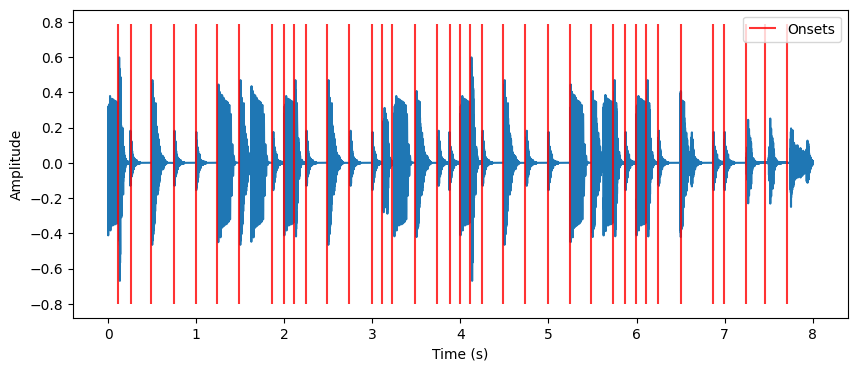

In [18]:
# extract onset frames, times and samples from reference audio
onset_frames, onset_times, onset_samples = extract_onset_information (audio=original_audio)

onset_env = librosa.onset.onset_strength(y=original_audio, sr=sr, lag=1)
onset_env /= max(onset_env)

D = np.abs(librosa.stft(original_audio, hop_length=512, window=scipy.signal.windows.bartlett, n_fft=2048))**2
onset_env2 = librosa.onset.onset_strength(sr=sr, lag=1, S=D)
onset_env2 /= max(onset_env2)

# Plot the onset envelope
plt.figure(figsize=(10, 4))
plt.plot(time_ms, original_audio)
plt.vlines(onset_times, -0.8, 0.79, color='r', alpha=0.8, label='Onsets')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


# listen to extracted onset events
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(original_audio))
ipd.Audio(original_audio + clicks, rate=sr)

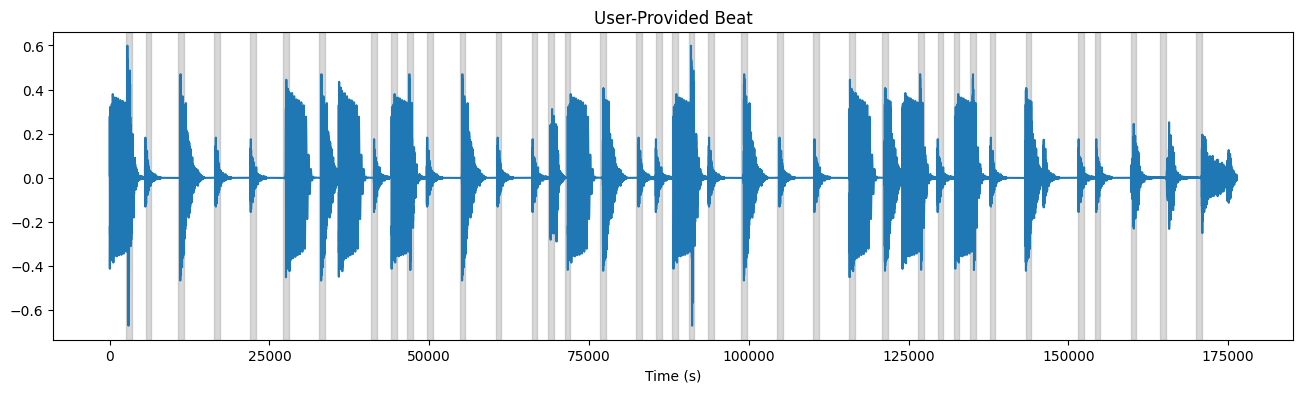

In [19]:
# define the frame size to be analyzed
frame_sz = sr*0.04 #100ms

#plot
samples = np.linspace(0, len(original_audio), len(original_audio)) # x axis
plt.figure(figsize=(16,4))
plt.plot(samples,original_audio)

# Frame_sz visualization
for i in onset_samples:
    plt.axvspan(i, i + frame_sz, color='gray', alpha=0.3)  # Semi-transparent gray
plt.xlabel("Time (s)")  # Label for clarity
plt.title('User-Provided Beat')
# plt.xlim(25000,50000)
plt.show()
plt.close()

In [20]:
# 2.2.2. Feature Extraction of the EB

# run extract_features across the onset samples
features = [extract_features(original_audio[i:int(i + frame_sz)]) for i in onset_samples]

# Normalization of Data, scale from -1 to 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
features_norm = min_max_scaler.fit_transform(features)

# create dataframe
df = pd.DataFrame(features, columns=["Flatness", "Mean Centroid"])

# add onset frames, times and samples from reference audio to df
onsets = extract_onset_information (audio=original_audio)
onset_labels = ['Onset Frames', 'Onset Times', 'Onset Samples']

for idx, label in enumerate(onset_labels):
    df[label] = onsets[idx]  # Assign the full column

# reorder
df = df[onset_labels + ["Flatness", "Mean Centroid"]]  # Explicit reordering

# Add normalized features
for i, col in enumerate(["Flatness", "Mean Centroid"]):
    df[f"{col}_norm"] = features_norm[:, i]

# Display the DataFrame
print(df)

    Onset Frames  Onset Times  Onset Samples  Flatness  Mean Centroid  \
0              5     0.116100           2560  0.053236    4331.042532   
1             11     0.255420           5632  0.130602    7260.252015   
2             21     0.487619          10752  0.299179    4255.622241   
3             32     0.743039          16384  0.086786    7256.758592   
4             43     0.998458          22016  0.089117    7255.589113   
5             53     1.230658          27136  0.026749    2869.494118   
6             64     1.486077          32768  0.299556    4256.577514   
7             80     1.857596          40960  0.136793    7219.082343   
8             86     1.996916          44032  0.000663     836.353473   
9             91     2.113016          46592  0.003407    3434.151950   
10            97     2.252336          49664  0.171917    7355.983912   
11           107     2.484535          54784  0.304995    4249.888270   
12           118     2.739955          60416  0.087

C:\Users\LEGION\PycharmProjects\GuessTheSnare\venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(


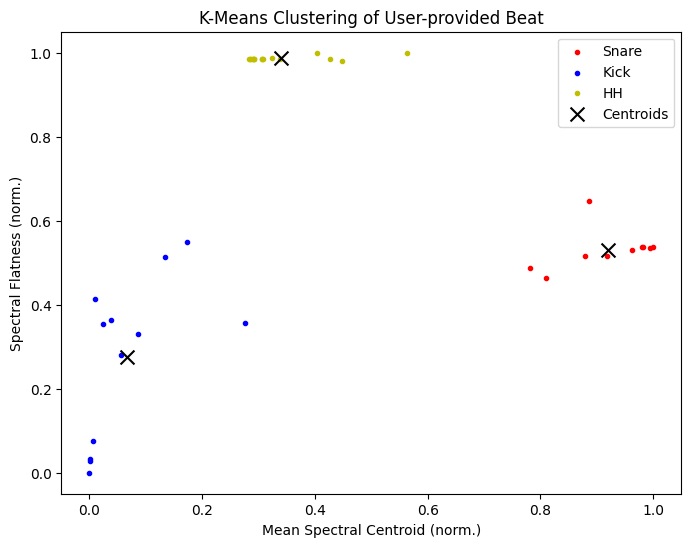

   Onset Frames  Onset Times  Onset Samples  Flatness  Mean Centroid  \
0             5     0.116100           2560  0.053236    4331.042532   
1            11     0.255420           5632  0.130602    7260.252015   
2            21     0.487619          10752  0.299179    4255.622241   
3            32     0.743039          16384  0.086786    7256.758592   
4            43     0.998458          22016  0.089117    7255.589113   

   Flatness_norm  Mean Centroid_norm  Cluster   Drum Color  
0       0.172951            0.548512        1   Kick     b  
1       0.427103            0.985712        2     HH     y  
2       0.980893            0.537255        0  Snare     r  
3       0.283165            0.985190        2     HH     y  
4       0.290823            0.985016        2     HH     y  


In [21]:
# 2.2.3. Clustering with K-Means (KM)

# K-Means clustering
n_clusters = 3  # 3 drum types: Kick, Snare, HH
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(features_norm)

# Manually define cluster-label mapping based on centroid positions
centroids = kmeans.cluster_centers_

# Assign labels based on centroid positions
cluster_labels = {}
cluster_colors = {}

# create cluster label based on drum sound perception and clusters
for i, (x, y) in enumerate(centroids):
    if x < 0.5 and y < 0.6:
        cluster_labels[i] = "Kick"
        cluster_colors[i] = 'b'
    elif x > 0.5 and y < 0.8:
        cluster_labels[i] = "Snare"
        cluster_colors[i] = 'r'
    elif x < 0.7 and y > 0.6:
        cluster_labels[i] = "HH"
        cluster_colors[i] = 'y'
    else:
        cluster_labels[i] = f"Cluster {i}"  # Default label
        cluster_colors[i] = 'k'  # Black for unknown clusters

df['Drum'] = df['Cluster'].map(cluster_labels)
df['Color'] = df['Cluster'].map(cluster_colors)

# plot
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    cluster_points = df[df['Cluster'] == i]
    plt.scatter(cluster_points['Flatness_norm'], cluster_points['Mean Centroid_norm'], 
                c=cluster_colors[i], label=cluster_labels[i], marker='.')

# add centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label="Centroids")
plt.xlabel("Mean Spectral Centroid (norm.)")
plt.ylabel("Spectral Flatness (norm.)")
plt.legend()
plt.title("K-Means Clustering of User-provided Beat")
plt.show()

print(df.head())

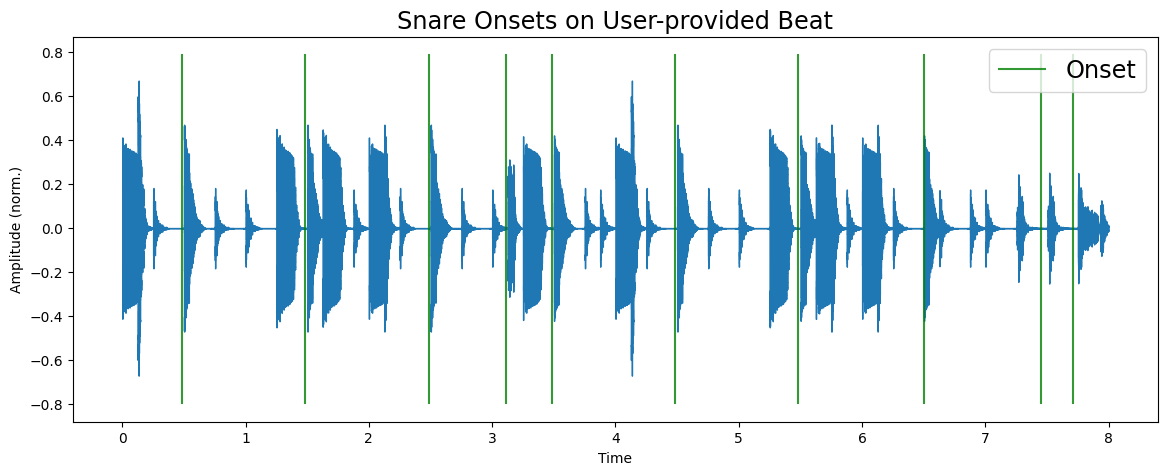

In [22]:
# 2.2.4 Extract and access data from resulting clusters

# snare samples
condition = df['Drum'] == 'Snare'

# # plot snare onsets upon the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(original_audio, sr=sr)
plt.vlines(df.loc[condition, 'Onset Times'], -0.8, 0.79, color='g', alpha=0.8, label='Onset')
plt.ylabel('Amplitude (norm.)')
plt.title('Snare Onsets on User-provided Beat', fontsize = 'xx-large')
plt.legend(fontsize='xx-large')
#plt.savefig('on_sets_sn.png')
plt.show()

# write wav files for all clusters with click
clicks = librosa.clicks(frames=df.loc[condition, 'Onset Frames'], sr=sr, length=len(original_audio))
ipd.Audio(original_audio + clicks, rate=sr)

In [23]:
# 2.2.5 Load and preprocess drum data set to search for sonically similar samples 
path = r"C:\Users\LEGION\PycharmProjects\GTS DATA SET"
user_ds = Path(path)
audio = r"C:\Users\LEGION\PycharmProjects\GTS DATA SET\BeatClean.wav"

# set the Drum type we are looking for
drum_type = 'Snare'

n_fft = 1024
loaded_ds = []
for i in user_ds.iterdir():
    
    # avoid reloading user-provided beat
    if str(i) == audio:
        pass
    
    else:
        loaded_ds.append({
            "File": i.name,
            "sr": librosa.load(i)[1],
            "Flatness": extract_features(librosa.load(i)[0], n_fft=n_fft)[0],
            "Mean Centroid": extract_features(librosa.load(i)[0], n_fft=n_fft)[1],
            "Drum": drum_type
        })

# create dataset, add normalized features
dataset_df = pd.DataFrame(loaded_ds)
dataset_feat_norm = min_max_scaler.fit_transform(dataset_df[["Flatness", "Mean Centroid"]])
for i, col in enumerate(dataset_df[["Flatness", "Mean Centroid"]]):
    dataset_df[f"{col}_norm"] = dataset_feat_norm[:, i]
print(dataset_df)

           File     sr  Flatness  Mean Centroid   Drum  Flatness_norm  \
0   Snare01.wav  22050  0.019854    1253.940793  Snare       0.055358   
1   Snare02.wav  22050  0.171449    3896.928580  Snare       0.504372   
2   Snare03.wav  22050  0.142147    3216.528588  Snare       0.417580   
3   Snare04.wav  22050  0.027243    2799.864877  Snare       0.077243   
4   Snare05.wav  22050  0.291258    3830.162336  Snare       0.859237   
5   Snare06.wav  22050  0.329962    6265.075123  Snare       0.973876   
6   Snare07.wav  22050  0.166708    2956.774794  Snare       0.490327   
7   Snare08.wav  22050  0.049781    4634.967905  Snare       0.143999   
8   Snare09.wav  22050  0.001558    2841.552520  Snare       0.001165   
9   Snare10.wav  22050  0.013613    2578.270607  Snare       0.036872   
10  Snare11.wav  22050  0.028979    3949.641675  Snare       0.082384   
11  Snare12.wav  22050  0.090166    3599.041280  Snare       0.263615   
12  Snare13.wav  22050  0.031197    2961.713252  Sn

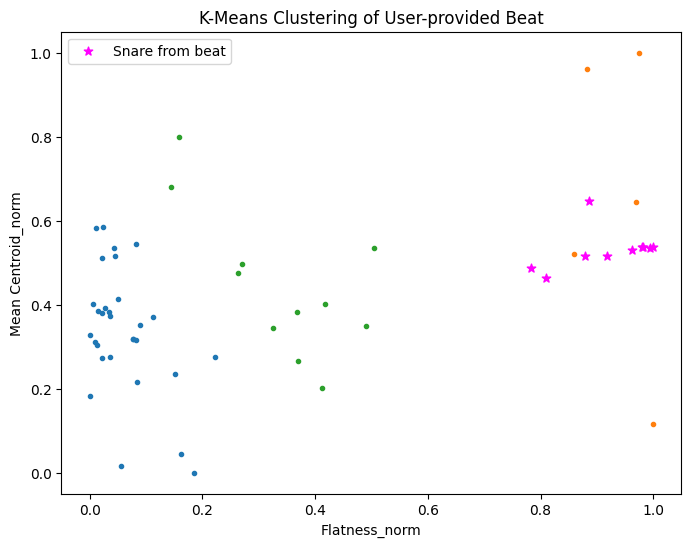

In [24]:
# 2.2.6. Clustering drum data set

n_clusters = 4  # this number may vary
dataset_df['Cluster'] = kmeans.fit_predict(dataset_feat_norm)

# Manually define cluster-label mapping based on centroid positions
dataset_centroids = kmeans.cluster_centers_

# plot
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    cluster_points = dataset_df[dataset_df['Cluster'] == i]
    plt.scatter(cluster_points['Flatness_norm'], cluster_points['Mean Centroid_norm'], marker='.')#, 
                # c=cluster_colors[i], label=cluster_labels[i], marker='.')

# Plot 'Snare' samples from user-provided beat
cluster_points = df[df['Drum'] == drum_type]
plt.scatter(cluster_points['Flatness_norm'], cluster_points['Mean Centroid_norm'], c='magenta', marker='*', label=f"{drum_type} from beat", s=40)

plt.xlabel("Flatness_norm")
plt.ylabel("Mean Centroid_norm")
plt.legend()
plt.title("K-Means Clustering of User-provided Beat")
plt.show()


In [25]:
# 2.2.7. Euclidean distance calculation

df_filtered = df[df['Drum'] == drum_type]
dataset_df_filtered = dataset_df[dataset_df['Drum'] == drum_type]

# Assuming df1 and df2 contain 'Flatness_norm' and 'Mean Centroid_norm' columns
points1 = df_filtered[['Flatness_norm', 'Mean Centroid_norm']].values
points2 = dataset_df_filtered[['Flatness_norm', 'Mean Centroid_norm']].values

# Compute pairwise distances between points from df1 and df2
dist_matrix = cdist(points1, points2, metric='euclidean')

# Find the indices of the minimum distance
min_distance_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)

# Get the closest points from each dataframe
point1_index = min_distance_idx[0]  # Index in df1
point2_index = min_distance_idx[1]  # Index in df2
min_distance = dist_matrix[point1_index, point2_index]


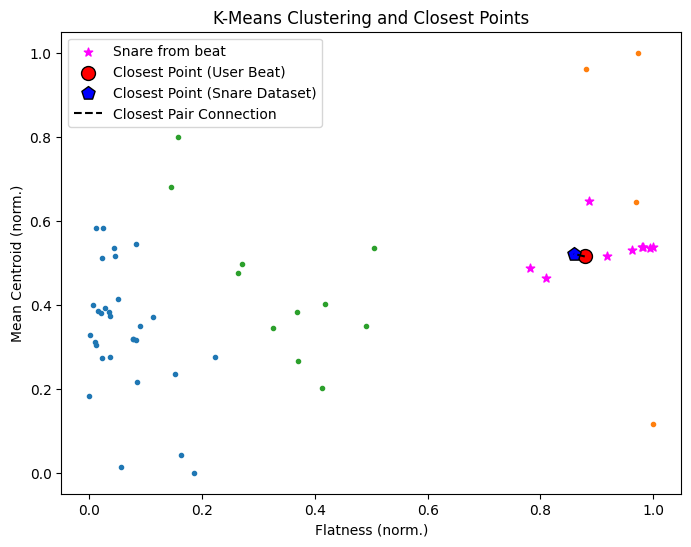

Closest points are from the Snare index 16 from your beat and the file Snare05.wav from your dataset with a distance of 0.02058256116275012!


In [26]:
# 2.2.7. Plot the closest data points

# Get the coordinates of the closest points
closest_point1 = df_filtered.iloc[point1_index][['Flatness_norm', 'Mean Centroid_norm']].values
closest_point2 = dataset_df_filtered.iloc[point2_index][['Flatness_norm', 'Mean Centroid_norm']].values

# Plot clustering results
plt.figure(figsize=(8, 6))

# Plot all clustered points
for i in range(n_clusters):
    cluster_points = dataset_df[dataset_df['Cluster'] == i]
    plt.scatter(cluster_points['Flatness_norm'], cluster_points['Mean Centroid_norm'], marker='.')

# Plot all user-provided 'drum_type' points
plt.scatter(df_filtered['Flatness_norm'], df_filtered['Mean Centroid_norm'], c='magenta', marker='*', label=f"{drum_type} from beat", s=40)

# Highlight the two closest points
plt.scatter(closest_point1[0], closest_point1[1], c='red', marker='o', edgecolors='black', s=100, label="Closest Point (User Beat)")
plt.scatter(closest_point2[0], closest_point2[1], c='blue', marker='p', edgecolors='black', s=100, label=f"Closest Point ({drum_type} Dataset)")

# Draw a line connecting the two closest points
plt.plot([closest_point1[0], closest_point2[0]], [closest_point1[1], closest_point2[1]], 'k--', label="Closest Pair Connection")

# Labels and title
plt.xlabel("Flatness (norm.)")
plt.ylabel("Mean Centroid (norm.)")
plt.legend()
plt.title("K-Means Clustering and Closest Points")
plt.show()

file_name = dataset_df_filtered.iloc[point2_index]['File']
print(f"Closest points are from the {drum_type} index {df_filtered.index[point1_index]} from your beat and the file {file_name} from your dataset with a distance of {min_distance}!")


In [27]:
# 2.2.8. Play the extracted snare and the recommended sound

# Get file paths
file2_path = dataset_df_filtered.iloc[point2_index]['File']   # Closest match in dataset
file2_path = user_ds / file2_path 
print(path, file2_path)

# Load full user-provided beat recording
y, sr = librosa.load(audio, sr=None, duration=8)

# Get onset info (assumes you have onset time in seconds)
onset_time = df_filtered.iloc[point1_index]['Onset Times']  # Onset time in seconds

# Convert onset time to sample index
start_sample = int(onset_time * sr)
end_sample = int((onset_time + 0.2) * sr)

# Extract the sample
user_sample = y[start_sample:end_sample]

# Load the closest match file
y2, sr2 = librosa.load(file2_path, sr=None)

# Play the extracted user sample
print(f"Playing extracted user sample from {audio} (Onset: {onset_time}s)")
display(ipd.Audio(user_sample, rate=sr))  # ✅ Use display() to ensure playback

# Play the closest matching file
print(f"Playing closest matching file: {file2_path}")
display(ipd.Audio(y2, rate=sr2))  # ✅ Ensure this is displayed too


C:\Users\LEGION\PycharmProjects\GTS DATA SET C:\Users\LEGION\PycharmProjects\GTS DATA SET\Snare05.wav
Playing extracted user sample from C:\Users\LEGION\PycharmProjects\GTS DATA SET\BeatClean.wav (Onset: 3.4829931972789114s)


Playing closest matching file: C:\Users\LEGION\PycharmProjects\GTS DATA SET\Snare05.wav
